In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from random import shuffle
import sklearn
from sklearn.utils import shuffle
import seaborn as sns
import pickle
import os
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

Data Collection

In [4]:
def all_listed_stocks(start_date, end_date):
    sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    last_tickers = sp500[0]['Symbol'].tolist()
    old_tickers = sp500[1].Removed.Ticker.unique()
    all_tickers = list(set(list(last_tickers) + list(old_tickers)))
    #changed to only current tickers
    print('Over the period', len(last_tickers), ' different stocks were part of the SnP')
    return last_tickers

def get_data_batch(tickers, start_date, end_date):
    data = {}
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            data[ticker] = stock.history(start=start_date, end=end_date)
        except:
            print(f"Failed to fetch data for {ticker}")
    return data

def get_non_empty_data(dico):
    non_empty_data = {}
    for ticker, df in dico.items():
        if not df.empty:
            non_empty_data[ticker] = df
    return non_empty_data

def tickers_with_nan(dico):
    non_empty_full_data = get_non_empty_data(dico)
    tickers_with_nan = []
    for ticker in non_empty_full_data.keys():
        if non_empty_full_data[ticker].isna().any().any():
            tickers_with_nan.append(ticker)

    if tickers_with_nan:
        print(f"Tickers with some NaN : {tickers_with_nan}")
    else:
        print("No tickers contains any NaN.")

Generating Signals and Images 

In [5]:
def create_candlestick_image(ohlc_data, size=(30, 30)):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_axis_off()

    indices = np.arange(len(ohlc_data))
    up = ohlc_data[ohlc_data['Close'] >= ohlc_data['Open']]
    down = ohlc_data[ohlc_data['Close'] < ohlc_data['Open']]

    up_indices = np.where(ohlc_data['Close'] >= ohlc_data['Open'])[0]
    down_indices = np.where(ohlc_data['Close'] < ohlc_data['Open'])[0]

    # Plot up candles
    ax.bar(up_indices, up['Close'] - up['Open'], 0.6, bottom=up['Open'], color='white', edgecolor='black')
    ax.vlines(up_indices, up['Low'], up['Open'], color='black', linewidth=1)
    ax.vlines(up_indices, up['Close'], up['High'], color='black', linewidth=1)

    # Plot down candles
    ax.bar(down_indices, down['Close'] - down['Open'], 0.6, bottom=down['Open'], color='black', edgecolor='black')
    ax.vlines(down_indices, down['Low'], down['Open'], color='black', linewidth=1)
    ax.vlines(down_indices, down['Close'], down['High'], color='black', linewidth=1)


    buffer = BytesIO()
    plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight', pad_inches=0)
    buffer.seek(0)
    image = Image.open(buffer)

    image = image.resize(size, Image.LANCZOS)
    plt.close()

    return np.array(image.convert('L'))


def calculate_bb(data, window=20, num_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return pd.DataFrame({'Upper': upper_band, 'Lower': lower_band, 'Close': data['Close']})


def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))


def calculate_macd(data, fast=12, slow=26, signal=9):
    exp1 = data['Close'].ewm(span=fast, adjust=False).mean()
    exp2 = data['Close'].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return pd.DataFrame({'MACD': macd, 'Signal': signal_line})


def generate_labels(data):
    bb = calculate_bb(data)
    rsi = calculate_rsi(data)
    macd = calculate_macd(data)

    bb_label = (data['Close'] > bb['Lower']).astype(int)
    rsi_label = (rsi > 30).astype(int)
    macd_label = ((macd['MACD'] > macd['Signal']) & (macd['MACD'].shift(1) <= macd['Signal'].shift(1))).astype(int)
    #above we put a positive signal only when the MACD lines CROSSES the signal line, gowing up.

    return pd.DataFrame({'BB': bb_label, 'RSI': rsi_label, 'MACD': macd_label})


def generate_sell_labels(data):
    bb = calculate_bb(data)
    rsi = calculate_rsi(data)
    macd = calculate_macd(data)

    bb_label = (data['Close'] > bb['Upper']).astype(int)
    rsi_label = (rsi > 70).astype(int)
    macd_label = ((macd['MACD'] < macd['Signal']) & (macd['MACD'].shift(1) >= macd['Signal'].shift(1))).astype(int)

    return pd.DataFrame({'BB': bb_label, 'RSI': rsi_label, 'MACD': macd_label})


def extract_ohlc_windows(data, samples_per_class=10, window_size_bb=20, window_size_macd=26, window_size_rsi=27):
    ohlc_windows = {
        'BB': {'buy': [], 'no_buy': []},
        'RSI': {'buy': [], 'no_buy': []},
        'MACD': {'buy': [], 'no_buy': []}
    }

    for ticker, df in data.items():
        df_labels = generate_labels(df)

        for indicator in ['BB', 'RSI', 'MACD']:
            if indicator == 'BB':
                window_size = window_size_bb
            elif indicator == 'MACD':
                window_size = window_size_macd
            elif indicator == 'RSI':
                window_size = window_size_rsi

            buy_indices = df_labels[df_labels[indicator] == 1].index
            no_buy_indices = df_labels[df_labels[indicator] == 0].index

            buy_samples = np.random.choice(buy_indices, min(samples_per_class, len(buy_indices)), replace=False)
            no_buy_samples = np.random.choice(no_buy_indices, min(samples_per_class, len(no_buy_indices)), replace=False)

            for idx in buy_samples:
                if df.index.get_loc(idx) >= window_size:
                    ohlc_window = df.loc[idx-pd.Timedelta(days=window_size):idx]
                    ohlc_windows[indicator]['buy'].append(ohlc_window)

            for idx in no_buy_samples:
                if df.index.get_loc(idx) >= window_size:
                    ohlc_window = df.loc[idx-pd.Timedelta(days=window_size):idx]
                    ohlc_windows[indicator]['no_buy'].append(ohlc_window)

    return ohlc_windows


def generate_images_from_ohlc(ohlc_windows, size=(30, 30), max_samples=5000):
    images = {
        'BB': {'buy': [], 'no_buy': []},
        'RSI': {'buy': [], 'no_buy': []},
        'MACD': {'buy': [], 'no_buy': []}
    }

    for indicator in ohlc_windows.keys():
        for label in ['buy', 'no_buy']:
            count = 0
            for ohlc_window in ohlc_windows[indicator][label]:
                #if count >= max_samples:
                #    break
                image = create_candlestick_image(ohlc_window, size=size)
                images[indicator][label].append(image)
                count += 1

    return images


Visualisng the Signals 

In [6]:
def plot_signals_with_indicators(data):

    plt.style.use('default')

    bb = calculate_bb(data)
    rsi = calculate_rsi(data)
    macd_data = calculate_macd(data)

    fig, axes = plt.subplots(3, 1, figsize=(15, 8))

    # 1. Bollinger Bands
    axes[0].plot(bb.index, bb['Close'], label='Close', color='black', linewidth=1.5)
    axes[0].plot(bb.index, bb['Upper'], label='Upper Band', color='red', linestyle='--')
    axes[0].plot(bb.index, bb['Lower'], label='Lower Band', color='blue', linestyle='--')
    axes[0].fill_between(bb.index, bb['Lower'], bb['Upper'], color='gray', alpha=0.2)
    axes[0].set_title('Bollinger Bands', fontsize=14)
    axes[0].legend(loc='upper left')
    axes[0].set_ylabel('Price')
    axes[0].grid(True)

    # 2. RSI
    axes[1].plot(rsi.index, rsi, label='RSI', color='purple', linewidth=1.5)
    axes[1].axhline(30, color='red', linestyle='--', label='Oversold (30)')
    axes[1].axhline(70, color='green', linestyle='--', label='Overbought (70)')
    axes[1].set_title('Relative Strength Index (RSI)', fontsize=14)
    axes[1].legend(loc='upper left')
    axes[1].set_ylabel('RSI Value')
    axes[1].grid(True)

    # 3. MACD
    axes[2].plot(macd_data.index, macd_data['MACD'], label='MACD', color='orange', linewidth=1.5)
    axes[2].plot(macd_data.index, macd_data['Signal'], label='Signal Line', color='blue', linewidth=1.5)
    axes[2].fill_between(macd_data.index, macd_data['MACD'] - macd_data['Signal'], color='gray', alpha=0.3, label='MACD - Signal')
    axes[2].set_title('MACD', fontsize=14)
    axes[2].legend(loc='upper left')
    axes[2].set_ylabel('Value')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


Processing and loading data 

In [7]:
import os
import pickle

def process_batch(data_batch, output_dir, batch_num, data_type, samples_per_class=10, size=30):
    ohlc_windows = extract_ohlc_windows(data_batch, samples_per_class)
    images = generate_images_from_ohlc(ohlc_windows, (size, size))
    for indicator in images.keys():
        for label in ['buy', 'no_buy']:
            filename = f"{indicator}_{label}_{data_type}_batch_{batch_num}_{size}.pkl"
            filepath = os.path.join(output_dir, filename)
            with open(filepath, 'wb') as f:
                pickle.dump(images[indicator][label], f)
    print(f"Batch {batch_num} ({data_type}) processed and saved.")

def load_batches(directory, data_type):
    all_images = {
        'BB': {'buy': [], 'no_buy': []},
        'RSI': {'buy': [], 'no_buy': []},
        'MACD': {'buy': [], 'no_buy': []}
    }
    for filename in os.listdir(directory):
        if filename.endswith('.pkl'):
            parts = filename.split('_')
            if len(parts) >= 4 and parts[-2] == 'batch' and parts[-3] == data_type:
                indicator = parts[0]
                label = 'buy' if parts[1] == 'buy' else 'no_buy'
                if indicator in all_images and label in all_images[indicator]:
                    with open(os.path.join(directory, filename), 'rb') as f:
                        batch_images = pickle.load(f)
                        all_images[indicator][label].extend(batch_images)
                else:
                    print(f"Skipping unexpected file: {filename}")
            else:
                print(f"Skipping file with unexpected format: {filename}")
    return all_images

def process_data(tickers, start_date, end_date, output_dir, data_type, batch_size=100, size=30):
    for i in range(0, len(tickers), batch_size):
        batch_tickers = tickers[i:i+batch_size]
        print(f"Processing {data_type} batch {i//batch_size + 1}")
        data_batch = get_data_batch(batch_tickers, start_date, end_date)
        process_batch(data_batch, output_dir, i//batch_size + 1, data_type, size=size)


In [8]:
# Define the date ranges
train_start = '2010-01-01'
train_end = '2014-12-31'
val_start = '2015-01-01'
val_end = '2017-12-31'
test_start = '2018-01-01'
test_end = '2019-12-31'
batch_size = 50  # Process 50 stocks at a time
output_dir = 'ohlc_images_batches'

# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

In [9]:
all_tickers = ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DAY', 'DECK', 'DE', 'DELL', 'DAL', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DHI', 'DTE', 'DUK', 'DD', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV', 'EMR', 'ENPH', 'ETR', 'EOG', 'EPAM', 'EQT', 'EFX', 'EQIX', 'EQR', 'ERIE', 'ESS', 'EL', 'EG', 'EVRG', 'ES', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS', 'FICO', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FI', 'FMC', 'F', 'FTNT', 'FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GE', 'GEHC', 'GEV', 'GEN', 'GNRC', 'GD', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GL', 'GDDY', 'GS', 'HAL', 'HIG', 'HAS', 'HCA', 'DOC', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUBB', 'HUM', 'HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'INCY', 'IR', 'PODD', 'INTC', 'ICE', 'IFF', 'IP', 'IPG', 'INTU', 'ISRG', 'IVZ', 'INVH', 'IQV', 'IRM', 'JBHT', 'JBL', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM', 'JNPR', 'K', 'KVUE', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KKR', 'KLAC', 'KHC', 'KR', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN', 'LLY', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LULU', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MTCH', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'META', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MRNA', 'MHK', 'MOH', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NKE', 'NI', 'NDSN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR', 'NXPI', 'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PLTR', 'PANW', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PEP', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PTC', 'PSA', 'PHM', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RVTY', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SJM', 'SW', 'SNA', 'SOLV', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STLD', 'STE', 'SYK', 'SMCI', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TRGP', 'TGT', 'TEL', 'TDY', 'TFX', 'TER', 'TSLA', 'TXN', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TRMB', 'TFC', 'TYL', 'TSN', 'USB', 'UBER', 'UDR', 'ULTA', 'UNP', 'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VLTO', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VTRS', 'VICI', 'V', 'VST', 'VMC', 'WRB', 'GWW', 'WAB', 'WBA', 'WMT', 'DIS', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WY', 'WMB', 'WTW', 'WYNN', 'XEL', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZTS']

In [10]:
# all_tickers = all_listed_stocks( train_start, test_end)
sample_tickers = all_tickers[:10]
data_sample = get_data_batch(sample_tickers, train_start, train_end)
sample_tickers[0]

'MMM'

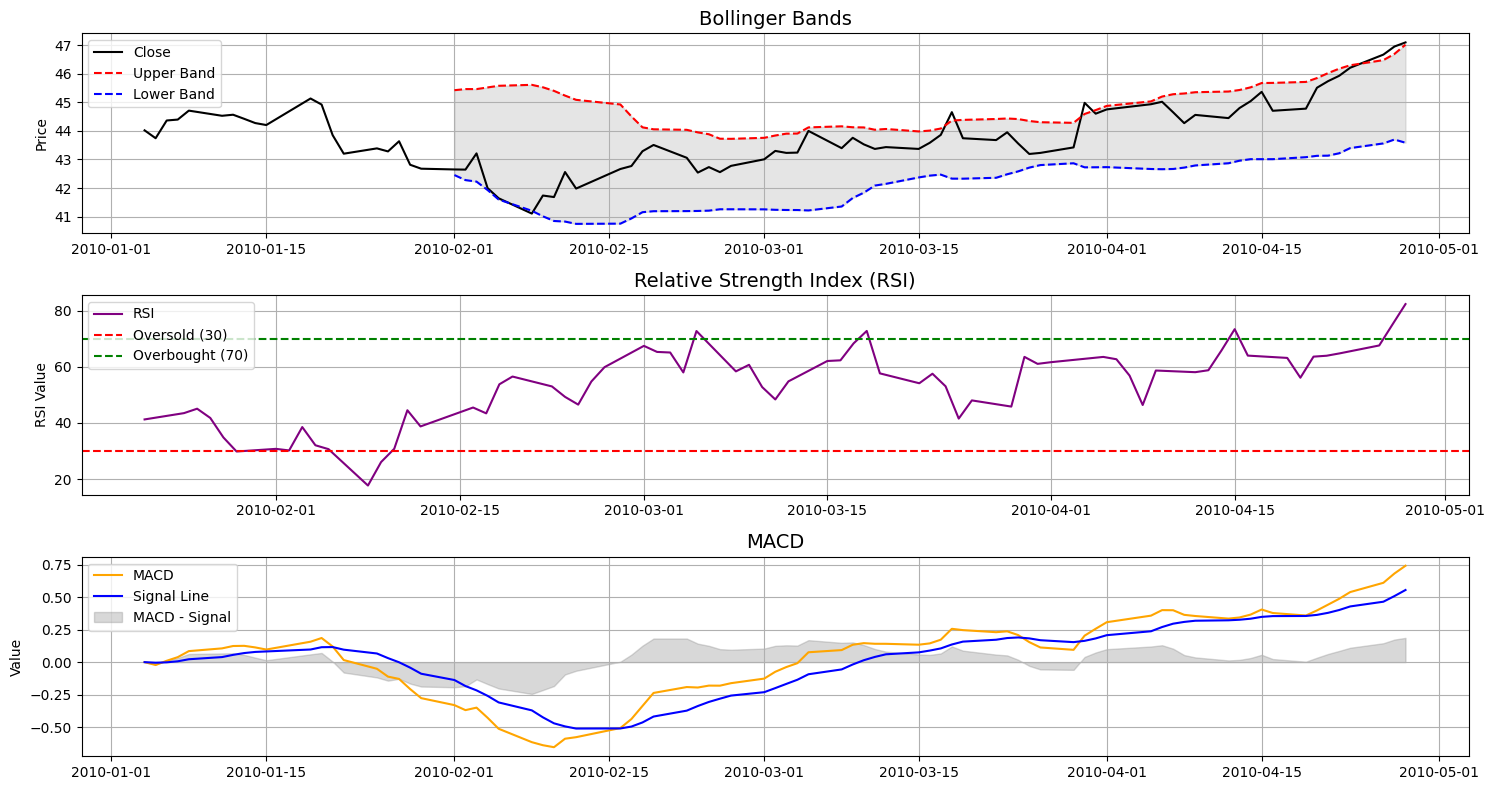

In [11]:
plot_signals_with_indicators(data_sample['MMM'][:80])

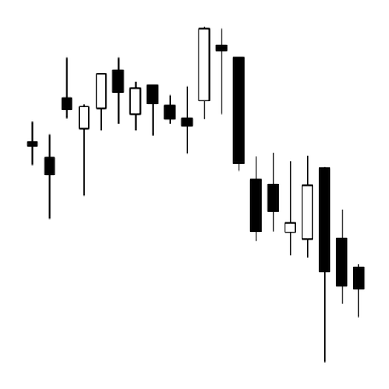

In [12]:
candlestick_image = create_candlestick_image(data_sample['MMM'][:20], size=(500, 500))
plt.imshow(candlestick_image, cmap='gray', interpolation='nearest')
plt.axis('off')  
plt.show()

Training Data

In [39]:
process_data(all_tickers, train_start, train_end, 'ohlc_images_batches', 'train')
process_data(all_tickers, val_start, val_end, 'ohlc_images_batches', 'val')
process_data(all_tickers, test_start, test_end, 'ohlc_images_batches', 'test')

Processing train batch 1


$ABNB: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$BRK.B: possibly delisted; no timezone found
$BF.B: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31)
$CARR: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")


Batch 1 (train) processed and saved.
Processing train batch 2


$CEG: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$CTVA: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$CRWD: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$DAY: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$DELL: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$DOW: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")


Batch 2 (train) processed and saved.
Processing train batch 3


$FTV: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$FOXA: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$FOX: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$GEHC: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$GEV: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$GDDY: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$HPE: possibly delisted; 

Batch 3 (train) processed and saved.
Processing train batch 4


$MRNA: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$OTIS: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$PLTR: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$PYPL: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$QRVO: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")


Batch 4 (train) processed and saved.
Processing train batch 5


$SW: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$SOLV: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$UBER: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$VLTO: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$VICI: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
$VST: possibly delisted; no price data found  (1d 2010-01-01 -> 2014-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1420002000")


: 

Implement various classifiers and the ensemble model

In [13]:
try:
    training_data = load_batches('/Users/samykobbite/Downloads/ohlc_images_batches', 'train')
    validation_data = load_batches('/Users/samykobbite/Downloads/ohlc_images_batches', 'val')
    testing_data = load_batches('/Users/samykobbite/Downloads/ohlc_images_batches', 'test')
    
    print("Data loaded successfully.")
    # Print some information about the loaded data
    for data_set, name in [(training_data, "Training"), (validation_data, "Validation"), (testing_data, "Testing")]:
        print(f"\n{name} Data:")
        for indicator in data_set:
            for label in data_set[indicator]:
                print(f"{indicator} - {label}: {len(data_set[indicator][label])} images")
except Exception as e:
    print(f"An error occurred while loading the data: {str(e)}")

Skipping file with unexpected format: MACD_no_buy_val_batch_5.pkl
Skipping file with unexpected format: RSI_buy_val_batch_3.pkl
Skipping file with unexpected format: RSI_buy_val_batch_2.pkl
Skipping file with unexpected format: MACD_no_buy_val_batch_4.pkl
Skipping file with unexpected format: MACD_no_buy_val_batch_6.pkl
Skipping file with unexpected format: RSI_buy_val_batch_1.pkl
Skipping file with unexpected format: MACD_no_buy_val_batch_3.pkl
Skipping file with unexpected format: RSI_buy_val_batch_5.pkl
Skipping file with unexpected format: RSI_buy_val_batch_4.pkl
Skipping file with unexpected format: MACD_no_buy_val_batch_2.pkl
Skipping file with unexpected format: RSI_buy_val_batch_6.pkl
Skipping file with unexpected format: MACD_no_buy_val_batch_1.pkl
Skipping file with unexpected format: RSI_buy_test_batch_6.pkl
Skipping file with unexpected format: BB_buy_test_batch_6.pkl
Skipping file with unexpected format: BB_buy_test_batch_4.pkl
Skipping file with unexpected format: RSI_buy

In [14]:
def prepare_data(data, indicator):
    X = []
    y = []
    for label in data[indicator]:
        X.extend(data[indicator][label])
        y.extend([1 if label == 'buy' else 0] * len(data[indicator][label]))
    return np.array(X), np.array(y)

def create_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, indicator):
    # Reshape the data for traditional ML models
    X_train_2d = X_train.reshape(X_train.shape[0], -1)
    X_val_2d = X_val.reshape(X_val.shape[0], -1)
    X_test_2d = X_test.reshape(X_test.shape[0], -1)

    # Standardize the data
    scaler = StandardScaler()
    X_train_2d = scaler.fit_transform(X_train_2d)
    X_val_2d = scaler.transform(X_val_2d)
    X_test_2d = scaler.transform(X_test_2d)

    # Define classifiers
    classifiers = {
        'Logistic Regression': LogisticRegression(),
        'Gaussian Naive Bayes': GaussianNB(),
        'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
        'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis(),
        'Gaussian Process': GaussianProcessClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Linear SVM': SVC(kernel='linear'),
        'RBF SVM': SVC(kernel='rbf'),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Extra Trees': ExtraTreesClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'Bagging': BaggingClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'Neural Net': MLPClassifier(hidden_layer_sizes=(32, 32, 32))
    }

    results = {}
    for name, clf in classifiers.items():
        print(f"Training {name} for {indicator}...")
        clf.fit(X_train_2d, y_train)
        y_pred = clf.predict(X_test_2d)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        results[name] = {'accuracy': accuracy, 'precision': precision}
        print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")

    # Train and evaluate CNN
    cnn = create_cnn()
    cnn.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)
    y_pred_cnn = (cnn.predict(X_test) > 0.5).astype(int)
    cnn_accuracy = accuracy_score(y_test, y_pred_cnn)
    cnn_precision = precision_score(y_test, y_pred_cnn, average='weighted')
    results['CNN'] = {'accuracy': cnn_accuracy, 'precision': cnn_precision}
    print(f"CNN - Accuracy: {cnn_accuracy:.4f}, Precision: {cnn_precision:.4f}")

    # Create ensemble model (excluding CNN)
    estimators = [(name, clf) for name, clf in classifiers.items()]
    ensemble = VotingClassifier(estimators=estimators, voting='hard')

    # Train and evaluate ensemble
    ensemble.fit(X_train_2d, y_train)
    y_pred_ensemble = ensemble.predict(X_test_2d)
    ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
    ensemble_precision = precision_score(y_test, y_pred_ensemble, average='weighted')
    results['Ensemble'] = {'accuracy': ensemble_accuracy, 'precision': ensemble_precision}
    print(f"Ensemble - Accuracy: {ensemble_accuracy:.4f}, Precision: {ensemble_precision:.4f}")

    # Perform cross-validation
    cv_scores = cross_val_score(ensemble, X_train_2d, y_train, cv=5)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    return results


In [15]:
indicators = ['BB', 'RSI', 'MACD']
all_results = {}

for indicator in indicators:
    print(f"\nProcessing {indicator}")

    # Prepare data for each set
    X_train, y_train = prepare_data(training_data, indicator)
    X_val, y_val = prepare_data(validation_data, indicator)
    X_test, y_test = prepare_data(testing_data, indicator)

    # Train and evaluate models
    results = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, indicator)
    all_results[indicator] = results

# Print final results
for indicator in indicators:
    print(f"\nFinal results for {indicator}:")
    for model, metrics in all_results[indicator].items():
        print(f"{model} - Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}")


Processing BB
Training Logistic Regression for BB...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Accuracy: 0.9390, Precision: 0.9399
Training Gaussian Naive Bayes for BB...
Gaussian Naive Bayes - Accuracy: 0.9077, Precision: 0.9195
Training Linear Discriminant Analysis for BB...
Linear Discriminant Analysis - Accuracy: 0.9393, Precision: 0.9418
Training Quadratic Discriminant Analysis for BB...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Quadratic Discriminant Analysis - Accuracy: 0.9016, Precision: 0.9092
Training Gaussian Process for BB...
Gaussian Process - Accuracy: 0.8224, Precision: 0.8520
Training K-Nearest Neighbors for BB...
K-Nearest Neighbors - Accuracy: 0.8450, Precision: 0.8815
Training Linear SVM for BB...
Linear SVM - Accuracy: 0.9306, Precision: 0.9317
Training RBF SVM for BB...
RBF SVM - Accuracy: 0.9560, Precision: 0.9579
Training Decision Tree for BB...
Decision Tree - Accuracy: 0.9135, Precision: 0.9151
Training Random Forest for BB...
Random Forest - Accuracy: 0.9589, Precision: 0.9607
Training Extra Trees for BB...
Extra Trees - Accuracy: 0.9593, Precision: 0.9611
Training AdaBoost for BB...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost - Accuracy: 0.9462, Precision: 0.9471
Training Bagging for BB...
Bagging - Accuracy: 0.9441, Precision: 0.9464
Training Gradient Boosting for BB...
Gradient Boosting - Accuracy: 0.9558, Precision: 0.9573
Training Neural Net for BB...
Neural Net - Accuracy: 0.9504, Precision: 0.9515
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7877 - loss: 0.8911 - val_accuracy: 0.8910 - val_loss: 0.2940
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9193 - loss: 0.2038 - val_accuracy: 0.9248 - val_loss: 0.1784
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9340 - loss: 0.1715 - val_accuracy: 0.9272 - val_loss: 0.1808
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9385 - loss: 0.1592 - val_accuracy: 0.9261 - val_loss: 0.2075
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9408 - loss: 0.1514 - val_accuracy: 0.8855 - val_loss: 0.2691
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9375 - loss: 0.1592 - val_accuracy: 0.9419 - val_loss: 0.1644
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9537 - loss: 0.1214 - val_accuracy: 0.9485 - val_loss: 0.1540
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9477 - loss: 0.1307 - val_accuracy: 0.9476 - val_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumven

Ensemble - Accuracy: 0.9554, Precision: 0.9580


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumven

Cross-validation scores: [0.95131086 0.95318352 0.96254682 0.96067416 0.94628357]
Mean CV score: 0.9548 (+/- 0.0121)

Processing RSI
Training Logistic Regression for RSI...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Accuracy: 0.8952, Precision: 0.8960
Training Gaussian Naive Bayes for RSI...
Gaussian Naive Bayes - Accuracy: 0.8508, Precision: 0.8692
Training Linear Discriminant Analysis for RSI...
Linear Discriminant Analysis - Accuracy: 0.8980, Precision: 0.9032
Training Quadratic Discriminant Analysis for RSI...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Quadratic Discriminant Analysis - Accuracy: 0.8710, Precision: 0.8735
Training Gaussian Process for RSI...
Gaussian Process - Accuracy: 0.7908, Precision: 0.8206
Training K-Nearest Neighbors for RSI...
K-Nearest Neighbors - Accuracy: 0.8044, Precision: 0.8529
Training Linear SVM for RSI...
Linear SVM - Accuracy: 0.8895, Precision: 0.8907
Training RBF SVM for RSI...
RBF SVM - Accuracy: 0.9228, Precision: 0.9270
Training Decision Tree for RSI...
Decision Tree - Accuracy: 0.8869, Precision: 0.8879
Training Random Forest for RSI...
Random Forest - Accuracy: 0.9320, Precision: 0.9356
Training Extra Trees for RSI...
Extra Trees - Accuracy: 0.9295, Precision: 0.9334
Training AdaBoost for RSI...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost - Accuracy: 0.9186, Precision: 0.9197
Training Bagging for RSI...
Bagging - Accuracy: 0.9225, Precision: 0.9259
Training Gradient Boosting for RSI...
Gradient Boosting - Accuracy: 0.9346, Precision: 0.9371
Training Neural Net for RSI...
Neural Net - Accuracy: 0.9129, Precision: 0.9140
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7468 - loss: 1.1997 - val_accuracy: 0.8483 - val_loss: 0.3295
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8898 - loss: 0.2697 - val_accuracy: 0.8848 - val_loss: 0.2768
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9051 - loss: 0.2276 - val_accuracy: 0.8879 - val_loss: 0.2593
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9146 - loss: 0.2056 - val_accuracy: 0.9032 - val_loss: 0.2321
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9216 - loss: 0.1997 - val_accuracy: 0.9107 - val_loss: 0.2189
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9211 - loss: 0.1905 - val_accuracy: 0.9117 - val_loss: 0.2123
Epoch 7/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9279 - loss: 0.1791 - val_accuracy: 0.8977 - val_loss: 0.3101
Epoch 8/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9219 - loss: 0.1888 - val_accuracy: 0.9054 - val_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumven

Ensemble - Accuracy: 0.9264, Precision: 0.9316


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumven

Cross-validation scores: [0.93808962 0.93160377 0.92040094 0.93632075 0.93038348]
Mean CV score: 0.9314 (+/- 0.0124)

Processing MACD
Training Logistic Regression for MACD...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Accuracy: 0.7497, Precision: 0.7499
Training Gaussian Naive Bayes for MACD...
Gaussian Naive Bayes - Accuracy: 0.7354, Precision: 0.7404
Training Linear Discriminant Analysis for MACD...
Linear Discriminant Analysis - Accuracy: 0.7462, Precision: 0.7466
Training Quadratic Discriminant Analysis for MACD...
Quadratic Discriminant Analysis - Accuracy: 0.7349, Precision: 0.7358
Training Gaussian Process for MACD...
Gaussian Process - Accuracy: 0.6597, Precision: 0.6599
Training K-Nearest Neighbors for MACD...
K-Nearest Neighbors - Accuracy: 0.6990, Precision: 0.7050
Training Linear SVM for MACD...
Linear SVM - Accuracy: 0.7523, Precision: 0.7527
Training RBF SVM for MACD...
RBF SVM - Accuracy: 0.7936, Precision: 0.7963
Training Decision Tree for MACD...
Decision Tree - Accuracy: 0.6976, Precision: 0.6977
Training Random Forest for MACD...
Random Forest - Accuracy: 0.8057, Precision: 0.8067
Training Extra Trees for MACD...
Extra Trees - Accuracy: 0.8011, Precision: 0.8

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost - Accuracy: 0.7649, Precision: 0.7649
Training Bagging for MACD...
Bagging - Accuracy: 0.7707, Precision: 0.7711
Training Gradient Boosting for MACD...
Gradient Boosting - Accuracy: 0.7941, Precision: 0.7949
Training Neural Net for MACD...
Neural Net - Accuracy: 0.7543, Precision: 0.7543
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5680 - loss: 2.3696 - val_accuracy: 0.6510 - val_loss: 0.6528
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6760 - loss: 0.6223 - val_accuracy: 0.6976 - val_loss: 0.5905
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7076 - loss: 0.5820 - val_accuracy: 0.6913 - val_loss: 0.5810
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7221 - loss: 0.5591 - val_accuracy: 0.7179 - val_loss: 0.5882
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7364 - loss: 0.5395 - val_accuracy: 0.7401 - val_loss: 0.5392
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7403 - loss: 0.5253 - val_accuracy: 0.7415 - val_loss: 0.5289
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7504 - loss: 0.5111 - val_accuracy: 0.7500 - val_loss: 0.5118
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7590 - loss: 0.4927 - val_accuracy: 0.7562 - val_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Ensemble - Accuracy: 0.7970, Precision: 0.7987


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (

Cross-validation scores: [0.80088252 0.7854385  0.79812466 0.81412024 0.80960265]
Mean CV score: 0.8016 (+/- 0.0199)

Final results for BB:
Logistic Regression - Accuracy: 0.9390, Precision: 0.9399
Gaussian Naive Bayes - Accuracy: 0.9077, Precision: 0.9195
Linear Discriminant Analysis - Accuracy: 0.9393, Precision: 0.9418
Quadratic Discriminant Analysis - Accuracy: 0.9016, Precision: 0.9092
Gaussian Process - Accuracy: 0.8224, Precision: 0.8520
K-Nearest Neighbors - Accuracy: 0.8450, Precision: 0.8815
Linear SVM - Accuracy: 0.9306, Precision: 0.9317
RBF SVM - Accuracy: 0.9560, Precision: 0.9579
Decision Tree - Accuracy: 0.9135, Precision: 0.9151
Random Forest - Accuracy: 0.9589, Precision: 0.9607
Extra Trees - Accuracy: 0.9593, Precision: 0.9611
AdaBoost - Accuracy: 0.9462, Precision: 0.9471
Bagging - Accuracy: 0.9441, Precision: 0.9464
Gradient Boosting - Accuracy: 0.9558, Precision: 0.9573
Neural Net - Accuracy: 0.9504, Precision: 0.9515
CNN - Accuracy: 0.9117, Precision: 0.9114
Ense

In [11]:
import matplotlib.pyplot as plt

def plot_accuracy_precision_with_custom_style(results):

    # Use a custom style temporarily for this function
    with plt.style.context('ggplot'):
        signals = ['BB', 'RSI', 'MACD']
        metrics = ['accuracy', 'precision']

        # Initialize figure
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Classifier Comparison by Accuracy and Precision for BB, RSI, and MACD Signals', fontsize=16)

        # Create subplots for each signal and metric
        for i, signal in enumerate(signals):
            # Extract data
            classifiers = list(results[signal].keys())
            accuracy = [results[signal][clf]['accuracy'] for clf in classifiers]
            precision = [results[signal][clf]['precision'] for clf in classifiers]

            # Accuracy subplot
            axs[0, i].bar(classifiers, accuracy, color='b')
            axs[0, i].set_title(f'{signal} - Accuracy', fontsize=12)
            axs[0, i].set_ylim(0.65, 1)
            axs[0, i].tick_params(axis='x', rotation=90)  # Rotate x labels for better readability

            # Precision subplot
            axs[1, i].bar(classifiers, precision, color='g')
            axs[1, i].set_title(f'{signal} - Precision', fontsize=12)
            axs[1, i].set_ylim(0.65, 1)
            axs[1, i].tick_params(axis='x', rotation=90)

        # Adjust layout for better appearance
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


In [12]:
plot_accuracy_precision_with_custom_style(all_results)

NameError: name 'all_results' is not defined

Multiple conclusions can be drawn from the above graph:

1) We get similar results as the one from the paper, i.e for the accuracy and the precision, we get a score of roughly 90%-95% for the RSI and the BB signals, and a score of 80% for the MACD signal.
2) The differences of results between the different classifiers are relatively small. Although the Quadratic Discriminator Analysis, teh Gaussian Process, and the K-nearest neighbors seems to do consistently worse than the other classifiers.
3) Although the ensemble method (majority voting of all the classifiers) seems to be working well, it does not seem that it is a necessary technique. Indeed, every single time, we get as good of an accuracy and of a precision simply by using the Extra Trees method or the Gradient Boosting.

Using the conclusion number 3), from now on, we will only train our model using Gradient Boosting, which will allow us to gain some training time.

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import pickle

def process_and_classify_images(tickers_data, start_date, end_date, output_dir, size=(30, 30)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images_by_indicator = {'BB': [], 'RSI': [], 'MACD': []}
    labels_by_indicator = {'BB': [], 'RSI': [], 'MACD': []}

    for ticker, data in tickers_data.items():
        data = data[(data.index >= start_date) & (data.index <= end_date)]
        labels_buy = generate_labels(data)  
        labels_sell = generate_sell_labels(data) 
        
        for i in range(len(data)):
            window = data.iloc[max(0, i - 30):i + 1]
            if len(window) < 30:
                continue  

            image = create_candlestick_image(window, size=size)

            for indicator in ['BB', 'RSI', 'MACD']:
                signal_buy = labels_buy[indicator].iloc[i]
                signal_sell = labels_sell[indicator].iloc[i]
                
                # Sauvegarder l'image dans le répertoire avec un nom descriptif
                if signal_buy == 1:
                    signal_label = 'buy'
                elif signal_sell == 1:
                    signal_label = 'sell'
                else:
                    signal_label = 'no_signal'

                filename = f"{ticker}_{indicator}_{signal_label}_{data.index[i].strftime('%Y-%m-%d')}.png"
                filepath = os.path.join(output_dir, filename)

                # Sauvegarder l'image
                plt.imsave(filepath, image, cmap='gray')

                # Classer l'image selon le signal
                images_by_indicator[indicator].append(image)
                labels_by_indicator[indicator].append(signal_label)

    return images_by_indicator, labels_by_indicator

# Entraîner le modèle de Gradient Boosting
def train_gradient_boosting(X_train, y_train, X_val, y_val, X_test, y_test):
    model = GradientBoostingClassifier()

    # Aplatir les images pour le modèle
    X_train = np.array([x.flatten() for x in X_train])
    X_val = np.array([x.flatten() for x in X_val])
    X_test = np.array([x.flatten() for x in X_test])

    model.fit(X_train, y_train)
    predictions_val = model.predict(X_val)
    predictions_test = model.predict(X_test)

    print("Validation set performance:")
    print(classification_report(y_val, predictions_val))
    
    print("Test set performance:")
    print(classification_report(y_test, predictions_test))
    
    return model

# Séparer les données selon les dates
def split_data_by_dates(tickers_data, train_start, train_end, val_start, val_end, test_start, test_end):
    train_data = {}
    val_data = {}
    test_data = {}

    for ticker, data in tickers_data.items():
        train_data[ticker] = data[(data.index >= train_start) & (data.index <= train_end)]
        val_data[ticker] = data[(data.index >= val_start) & (data.index <= val_end)]
        test_data[ticker] = data[(data.index >= test_start) & (data.index <= test_end)]

    return train_data, val_data, test_data

# Préparer les données (images et labels)
def prepare_data(images_by_indicator, labels_by_indicator):
    X = []
    y = []
    for img, label in zip(images_by_indicator, labels_by_indicator):
        X.append(img)
        y.append(label)
    return np.array(X), np.array(y)

In [14]:
three_stocks_data = get_data_batch(['AAPL', 'MSFT', 'GOOG'],'2010-01-01', '2019-12-31', )

In [15]:
import time

In [24]:
# Charger les données (exécuter directement dans le notebook)
tickers_data = three_stocks_data

# Dates de chaque set
train_start = '2010-01-01'
train_end = '2014-12-31'
val_start = '2015-01-01'
val_end = '2017-12-31'
test_start = '2018-01-01'
test_end = '2019-12-31'

# Dossier pour enregistrer les images
output_dir = '/Users/samykobbite/Documents/Berkeley/Term 3/Unsupervised Learning (ZB)'

time_1 = time.time()
# Séparation des données en train, validation et test sets
train_data, val_data, test_data = split_data_by_dates(tickers_data, train_start, train_end, val_start, val_end, test_start, test_end)
time_2 = time.time()
print(time_2 - time_1)
# Génération des images pour chaque set
images_train, labels_train = process_and_classify_images(train_data, train_start, train_end, output_dir)
time_3 = time.time()
print(time_3 - time_2)

images_val, labels_val = process_and_classify_images(val_data, val_start, val_end, output_dir)
time_4 = time.time()
print(time_4 - time_3)

images_test, labels_test = process_and_classify_images(test_data, test_start, test_end, output_dir)
time_5 = time.time()
print(time_5 - time_4)


0.0050449371337890625
127.26944518089294
443.86520195007324
54.597450971603394


In [16]:
models = {}

# Entraîner le modèle Gradient Boosting pour chaque indicateur
for indicator in ['BB', 'RSI', 'MACD']:
    print(f"Training Gradient Boosting for {indicator} signals...")

    X_train, y_train = prepare_data(images_train[indicator], labels_train[indicator])
    X_val, y_val = prepare_data(images_val[indicator], labels_val[indicator])
    X_test, y_test = prepare_data(images_test[indicator], labels_test[indicator])

    model = train_gradient_boosting(X_train, y_train, X_val, y_val, X_test, y_test)
    models[indicator] = model

output_model_dir = '/Users/samykobbite/Documents/Berkeley/Term 3/Unsupervised Learning (ZB)/trained_gradient_boosting_models.pkl'
with open(output_model_dir, 'wb') as f:
    pickle.dump(models, f)

print(f"Models succesfully saved in : {output_model_dir}")

Training Gradient Boosting for BB signals...


NameError: name 'images_train' is not defined

In [28]:
model_file_path = '/Users/samykobbite/Documents/Berkeley/Term 3/Unsupervised Learning (ZB)/trained_gradient_boosting_models.pkl'

with open(model_file_path, 'rb') as f:
    loaded_models = pickle.load(f)

print("Model succesfully downloaded")

Model succesfully downloaded


In [17]:
def generate_test_set_signals(loaded_models, test_set_images, image_size=(30, 30)):
    """
    Génère les signaux (buy, sell, no_signal) pour chaque action et chaque indicateur
    à partir des modèles chargés et des images du test set.
    
    :param loaded_models: Un dictionnaire des modèles chargés (BB, RSI, MACD).
    :param test_set_images: Un dictionnaire contenant les images du test set pour chaque action.
                            {'BB': {'AAPL': [img1, img2, ...], 'MSFT': ...}, 'RSI': ...}
    :param image_size: Taille à laquelle redimensionner les images (par défaut 30x30).
    
    :return: Un dictionnaire avec les signaux générés pour chaque indicateur et chaque action.
             {'BB': {'AAPL': ['buy', 'sell', 'no_signal', ...], 'MSFT': ...}, 'RSI': ...}
    """
    test_set_signals = {indicator: {} for indicator in ['BB', 'RSI', 'MACD']}
    
    for indicator in ['BB', 'RSI', 'MACD']:
        model = loaded_models[indicator]  # Récupérer le modèle pré-entraîné pour cet indicateur
        for action in test_set_images[indicator]:
            images = test_set_images[indicator][action]
            
            # Redimensionner les images à la taille attendue (par ex. 30x30) et convertir en niveaux de gris
            resized_images = [Image.fromarray(img).convert('L').resize(image_size) for img in images]
            
            # Aplatir les images pour les passer dans le modèle
            X_test = np.array([np.array(img).flatten() for img in resized_images])
            
            # Vérifier que le nombre de features correspond bien à celui attendu
            if X_test.shape[1] != model.n_features_in_:
                raise ValueError(f"Erreur de dimension : les images ont {X_test.shape[1]} features, mais le modèle attend {model.n_features_in_} features.")
            
            # Faire des prédictions (0 pour no_signal, 1 pour buy, -1 pour sell)
            predictions = model.predict(X_test)
            
            # Convertir les prédictions en labels (buy, sell, no_signal)
            signals = []
            for pred in predictions:
                if pred == 1:
                    signals.append('buy')
                elif pred == -1:  # Vérifier si ton modèle retourne bien -1 pour sell
                    signals.append('sell')
                else:
                    signals.append('no_signal')
            
            # Stocker les signaux pour cette action et cet indicateur
            test_set_signals[indicator][action] = signals
            
    return test_set_signals

In [18]:
def generate_test_set_signals(loaded_models, test_set_images, image_size=(30, 30)):
    """
    Génère les signaux (buy, sell, no_signal) pour chaque action et chaque indicateur
    à partir des modèles chargés et des images du test set.
    
    :param loaded_models: Un dictionnaire des modèles chargés (BB, RSI, MACD).
    :param test_set_images: Un dictionnaire contenant les images du test set pour chaque action.
                            {'BB': {'AAPL': [img1, img2, ...], 'MSFT': ...}, 'RSI': ...}
    :param image_size: Taille à laquelle redimensionner les images (par défaut 30x30).
    
    :return: Trois dictionnaires avec les signaux pour BB, RSI et MACD pour chaque action.
    """
    bb_signals = {}
    rsi_signals = {}
    macd_signals = {}
    
    for indicator in ['BB', 'RSI', 'MACD']:
        model = loaded_models[indicator]  # Récupérer le modèle pré-entraîné pour cet indicateur
        
        print(f"Classes utilisées pour {indicator}: {model.classes_}")
        
        for action in test_set_images[indicator]:
            images = test_set_images[indicator][action]
            
            # Redimensionner les images à la taille attendue et les convertir en niveaux de gris
            resized_images = [Image.fromarray(img).convert('L').resize(image_size) for img in images]
            
            # Aplatir les images pour les passer dans le modèle
            X_test = np.array([np.array(img).flatten() for img in resized_images])
            
            # Faire des prédictions
            predictions = model.predict(X_test)
            
            # Convertir les prédictions en labels (1 pour 'buy', -1 pour 'sell', 0 pour 'no_signal')
            signals = []
            for pred in predictions:
                if pred == 'buy':
                    signals.append(1)
                elif pred == 'sell':
                    signals.append(-1)
                else:
                    signals.append(0)
            
            # Stocker les signaux dans les bons dictionnaires pour chaque action
            if indicator == 'BB':
                bb_signals[action] = signals
            elif indicator == 'RSI':
                rsi_signals[action] = signals
            elif indicator == 'MACD':
                macd_signals[action] = signals
    
    return bb_signals, rsi_signals, macd_signals

In [19]:
import re

In [20]:
def load_test_set_images(directory, start_date, end_date):
    """
    Charge les images du test set en fonction des dates et les organise par action et indicateur.
    
    :param directory: Chemin du répertoire où les images sont stockées.
    :param start_date: Date de début du test set (format 'YYYY-MM-DD').
    :param end_date: Date de fin du test set (format 'YYYY-MM-DD').
    
    :return: Un dictionnaire organisé par indicateur puis par action.
             Exemple: {'BB': {'AAPL': [img1, img2, ...], 'MSFT': ...}, 'RSI': ...}
    """
    test_set_images = {'BB': {}, 'RSI': {}, 'MACD': {}}
    
    # Convertir les dates en format utilisable pour comparer
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Parcourir le répertoire des images
    for filename in os.listdir(directory):
        if filename.endswith('.png'):  # S'assurer qu'il s'agit d'une image
            # Extraire les informations du nom de fichier (par exemple: 'AAPL_BB_buy_2018-01-15.png')
            match = re.match(r"([A-Z]+)_([A-Z]+)_(buy|sell|no_signal)_(\d{4}-\d{2}-\d{2})\.png", filename)
            if match:
                ticker, indicator, signal, date_str = match.groups()
                image_date = pd.to_datetime(date_str)
                
                # Si l'image fait partie du test set (en fonction de la date)
                if start_date <= image_date <= end_date:
                    # Charger l'image
                    filepath = os.path.join(directory, filename)
                    image = Image.open(filepath)
                    image = np.array(image)  # Convertir en array

                    # Organiser les images par indicateur et par action
                    if ticker not in test_set_images[indicator]:
                        test_set_images[indicator][ticker] = []
                    test_set_images[indicator][ticker].append(image)
                    
    return test_set_images

In [21]:
# Chemin du répertoire où sont stockées les images
image_directory = '/Users/samykobbite/Documents/Berkeley/Term 3/Unsupervised Learning (ZB)/Three_images'

# Définir les dates de début et de fin du test set
test_start_date = '2018-01-01'
test_end_date = '2019-12-31'

# Charger les images du test set
test_set_images = load_test_set_images(image_directory, test_start_date, test_end_date)

# Vérifier la structure des images chargées
for indicator in test_set_images:
    for action in test_set_images[indicator]:
        print(f"{indicator} - {action}: {len(test_set_images[indicator][action])} images")

BB - MSFT: 473 images
BB - GOOG: 473 images
BB - AAPL: 473 images
RSI - AAPL: 473 images
RSI - MSFT: 473 images
RSI - GOOG: 473 images
MACD - MSFT: 473 images
MACD - GOOG: 473 images
MACD - AAPL: 473 images


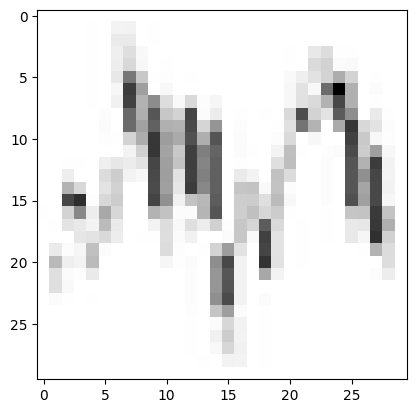

In [76]:
img_array = test_set_images['BB']['MSFT'][0]  # Premier élément de l'image 'BB' pour MSFT
plt.imshow(img_array, cmap='gray')
plt.show()

In [22]:
image = test_set_images['BB']['MSFT'][0]  # Exemple avec la première image de BB pour MSFT
print(f"Taille de l'image : {image.shape}")

Taille de l'image : (30, 30, 4)


In [23]:
len(generate_test_set_signals(loaded_models, test_set_images)[1]['GOOG'])

NameError: name 'loaded_models' is not defined

In [24]:
def apply_trading_strategy(bb_signals, rsi_signals, macd_signals, test_set_prices, initial_capital=100, risk_free_rate=0.02):
    days = test_set_prices.index
    actions = test_set_prices.columns

    # Calcul des returns journaliers des actions
    returns = test_set_prices.pct_change().fillna(0)  # Calculer les retours journaliers à partir des prix
    
    # Vérification que la longueur des signaux et des prix est la même
    min_length = min(len(days), len(next(iter(bb_signals.values()))), len(next(iter(rsi_signals.values()))), len(next(iter(macd_signals.values()))))
    days = days[:min_length]
    returns = returns.iloc[:min_length]  # Ajuster la longueur des retours aussi

    # Initialiser le capital et les positions
    capital = initial_capital
    portfolio_values = []
    positions = {action: [0] * min_length for action in actions}  # Liste des positions par action par jour
    risk_free_position = [capital]  # Capital non investi dans les actions
    portfolio_weights = {action: [0] * min_length for action in actions}  # Poids sur chaque action
    risk_free_weights = [1] * min_length  # Poids sur le risk-free rate initialisé à 1

    days_since_sell = {action: -np.inf for action in actions}

    for i, day in enumerate(days):
        tradable_actions = []
        buy_signals_count = {action: 0 for action in actions}

        for action in actions:
            if i - days_since_sell[action] < 4:  # Cooldown de 4 jours après un signal de vente
                positions[action][i] = 0  # Pas de position
            else:
                # Compter les signaux d'achat des 5 derniers jours
                buy_signals_last_5_days = sum([
                    bb_signals[action][j] == 1 or 
                    rsi_signals[action][j] == 1 or 
                    macd_signals[action][j] == 1 
                    for j in range(max(0, i - 4), i + 1)
                ])
                buy_signals_count[action] = buy_signals_last_5_days

                # Si un signal de vente est détecté aujourd'hui, mettre la position à zéro et marquer le jour de vente
                if bb_signals[action][i] == -1 or rsi_signals[action][i] == -1 or macd_signals[action][i] == -1:
                    days_since_sell[action] = i
                    positions[action][i] = 0  # Pas de position après un signal de vente
                else:
                    tradable_actions.append(action)

        # Allouer le capital basé sur les signaux d'achat
        if tradable_actions:
            total_buy_signals = sum(buy_signals_count[action] for action in tradable_actions)
            if total_buy_signals > 0:
                # Répartir les poids en fonction des signaux d'achat sur les 5 derniers jours
                total_weight_used = 0
                for action in tradable_actions:
                    ratio = buy_signals_count[action] / total_buy_signals if total_buy_signals > 0 else 0
                    weight = ratio  # Le poids alloué à cette action
                    portfolio_weights[action][i] = weight
                    total_weight_used += weight
                
                # Assigner le reste au risk-free rate
                risk_free_weights[i] = 1 - total_weight_used
            else:
                # Si aucun signal d'achat n'est présent, tout va au risk-free
                risk_free_weights[i] = 1
                for action in actions:
                    portfolio_weights[action][i] = 0
        else:
            # Si aucune action n'est tradable, tout va au risk-free
            risk_free_weights[i] = 1
            for action in actions:
                portfolio_weights[action][i] = 0

        # Calculer la valeur journalière du portefeuille
        if i > 0:
            daily_return = sum(
                portfolio_weights[action][i] * returns[action].iloc[i]
                for action in actions
            )
        else:
            daily_return = 0  # Pas de retour calculé le premier jour

        # Ajouter le rendement du taux sans risque pour le capital non investi
        risk_free_return = risk_free_weights[i] * (1 + risk_free_rate / 365 - 1)  # Ajouter rendement du taux sans risque
        total_daily_return = daily_return + risk_free_return

        # Mettre à jour la valeur du portefeuille en fonction du rendement cumulé
        portfolio_value = (portfolio_values[-1] if portfolio_values else capital) * (1 + total_daily_return)
        portfolio_values.append(portfolio_value)

    # Créer un DataFrame des positions et des valeurs du portefeuille
    portfolio_weights_df = pd.DataFrame(portfolio_weights, index=days)
    portfolio_values_df = pd.DataFrame({'Portfolio Value': portfolio_values}, index=days)

    return portfolio_weights_df, portfolio_values_df

In [25]:
def generate_test_set_prices(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    closing_prices = data['Adj Close'] if 'Adj Close' in data.columns else data['Close']
    closing_prices.columns = tickers
    return closing_prices


In [26]:
def generate_test_set_prices(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    closing_prices = data['Adj Close'] if 'Adj Close' in data.columns else data['Close']
    closing_prices.columns = tickers
    return closing_prices

In [27]:
three_stocks_tickers = ['MSFT', 'GOOG','AAPL']

test_set_prices = generate_test_set_prices(three_stocks_tickers, test_start_date, test_end_date)
test_set_prices

[*********************100%***********************]  3 of 3 completed


,MSFT,GOOG,AAPL
Date,,,
2018-01-02 00:00:00+00:00,40.568932,53.119549,79.792915
2018-01-03 00:00:00+00:00,40.561871,53.991409,80.164253
2018-01-04 00:00:00+00:00,40.750267,54.186928,80.869820
2018-01-05 00:00:00+00:00,41.214226,54.976486,81.872459
2018-01-08 00:00:00+00:00,41.061146,55.211411,81.956001
...,...,...,...
2019-12-23 00:00:00+00:00,68.908989,67.276779,150.861740
2019-12-24 00:00:00+00:00,68.974518,67.013428,150.832993
2019-12-26 00:00:00+00:00,70.342979,67.853355,152.069336


In [28]:
bb_signals , rsi_signals , macd_signals = generate_test_set_signals(loaded_models, test_set_images)
apply_trading_strategy(bb_signals , rsi_signals , macd_signals,test_set_prices)[0].plot()

NameError: name 'loaded_models' is not defined

<Axes: xlabel='Date'>

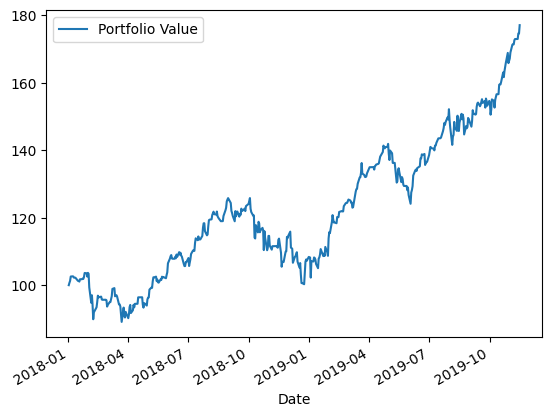

In [186]:
apply_trading_strategy(bb_signals , rsi_signals , macd_signals,test_set_prices)[1].plot()

In [187]:
def buy_and_hold_strategy(test_set_prices, initial_capital=100):
    days = test_set_prices.index
    actions = test_set_prices.columns

    # Calcul des retours journaliers des actions
    returns = test_set_prices.pct_change().fillna(0)  # Calculer les retours journaliers à partir des prix

    # Allouer le capital initial de manière égale entre toutes les actions
    equal_weight = 1 / len(actions)  # Poids égal pour chaque action
    initial_position = {action: (initial_capital * equal_weight) / test_set_prices[action].iloc[0] for action in actions}  # Nombre d'actions achetées au jour 0

    portfolio_values = []

    # Calculer la valeur du portefeuille au fil du temps
    for i, day in enumerate(days):
        # Valeur totale du portefeuille pour le jour en cours
        portfolio_value = sum(
            initial_position[action] * test_set_prices[action].iloc[i]
            for action in actions
        )
        portfolio_values.append(portfolio_value)

    # Créer un DataFrame avec la valeur du portefeuille au fil du temps
    portfolio_values_df = pd.DataFrame({'Portfolio Value': portfolio_values}, index=days)

    return portfolio_values_df

<Axes: xlabel='Date'>

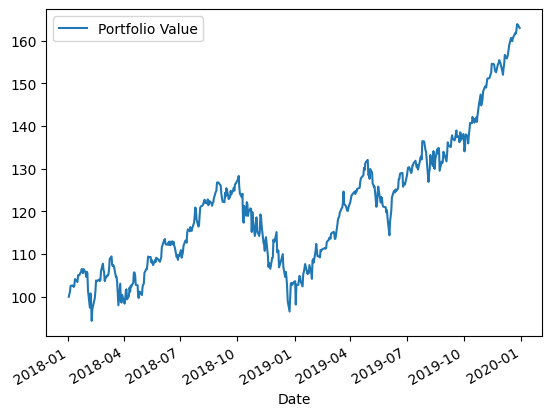

In [188]:
# Exécution de la stratégie Buy and Hold
buy_and_hold_results = buy_and_hold_strategy(test_set_prices, initial_capital=100)

# Afficher la valeur du portefeuille au fil du temps
buy_and_hold_results.plot()

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_portfolio_comparison(strategy1_values, strategy2_values, labels, title="Portfolio Value Comparison"):
    sns.set(style="whitegrid")  # Set a clean style using seaborn

    plt.figure(figsize=(12, 8))

    # Plot both portfolio values
    plt.plot(strategy1_values.index, strategy1_values['Portfolio Value'], label=labels[0], color='blue', linewidth=2)
    plt.plot(strategy2_values.index, strategy2_values['Portfolio Value'], label=labels[1], color='orange', linewidth=2)

    # Adding titles and labels
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Portfolio Value', fontsize=14)

    # Adding grid, legend and aesthetic touches
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc="upper left", fontsize=12, frameon=True, shadow=True, title="Strategies")
    plt.xticks(rotation=45)
    
    # Set the background color
    plt.gca().set_facecolor('whitesmoke')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

In [190]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [195]:
from tabulate import tabulate
import matplotlib.pyplot as plt

def create_performance_table(metrics_comparison, labels):
    # Convert DataFrame to list format for tabulate
    headers = ["Metric", labels[0], labels[1]]
    
    # Ensure all values are floats and format them as percentages
    data = [[metric, f"{float(metrics_comparison[labels[0]][metric]):.2%}", 
             f"{float(metrics_comparison[labels[1]][metric]):.2%}"] 
            for metric in metrics_comparison.index]

    # Create a table with tabulate
    table_str = tabulate(data, headers, tablefmt="fancy_grid")

    # Display the table in matplotlib
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')

    # Add the table as an image in the plot
    plt.table(cellText=data, colLabels=headers, cellLoc='center', loc='center', colWidths=[0.2, 0.15, 0.15])
    
    # Display the table
    plt.tight_layout()
    plt.show()

    return table_str

In [192]:
import numpy as np

def calculate_performance_metrics(portfolio_values, risk_free_rate=0.02):
    daily_returns = portfolio_values.pct_change().fillna(0)
    annualized_return = (1 + daily_returns.mean())**252 - 1  # 252 jours de trading par an
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Maximum drawdown calculation
    cumulative_returns = (1 + daily_returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdowns = cumulative_returns / rolling_max - 1
    max_drawdown = drawdowns.min()

    # Sortino Ratio (downside volatility)
    downside_returns = daily_returns[daily_returns < 0]
    downside_volatility = downside_returns.std() * np.sqrt(252)
    sortino_ratio = (annualized_return - risk_free_rate) / downside_volatility

    # Calmar Ratio
    calmar_ratio = annualized_return / abs(max_drawdown)

    metrics = {
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio
    }

    return metrics

In [193]:
import pandas as pd

def compare_strategies_metrics(strategy1_values, strategy2_values, labels):
    metrics1 = calculate_performance_metrics(strategy1_values)
    metrics2 = calculate_performance_metrics(strategy2_values)

    comparison_df = pd.DataFrame({
        labels[0]: metrics1,
        labels[1]: metrics2
    })

    # Affichage du tableau
    print(comparison_df)
    return comparison_df

In [209]:
compare_strategies_metrics(apply_trading_strategy(bb_signals, rsi_signals, macd_signals, test_set_prices),buy_and_hold_strategy(test_set_prices) , ["Trading Strategy", "Buy and Hold"])

AttributeError: 'tuple' object has no attribute 'pct_change'

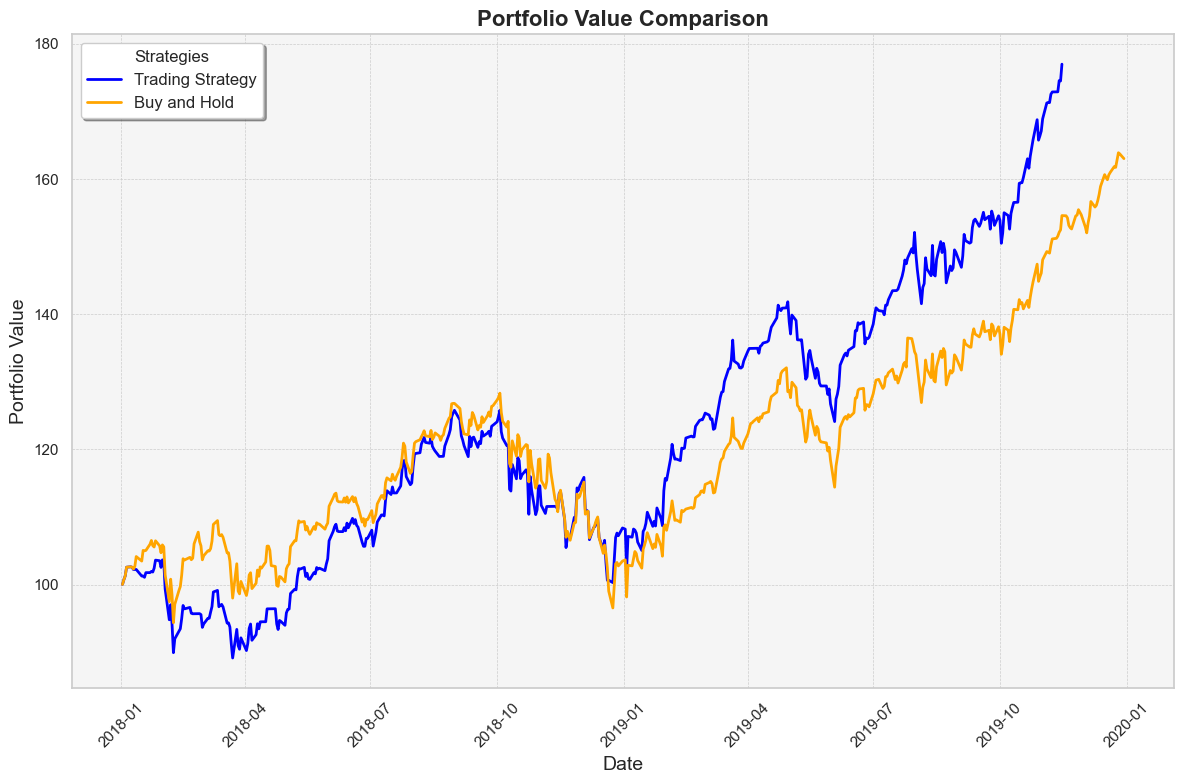

                                                 Trading Strategy  \
Annualized Return      Portfolio Value    0.392645
dtype: float64   
Annualized Volatility  Portfolio Value    0.232358
dtype: float64   
Sharpe Ratio            Portfolio Value    1.60375
dtype: float64   
Max Drawdown           Portfolio Value   -0.202823
dtype: float64   
Sortino Ratio          Portfolio Value    1.978661
dtype: float64   
Calmar Ratio           Portfolio Value    1.935902
dtype: float64   

                                                     Buy and Hold  
Annualized Return      Portfolio Value    0.312169
dtype: float64  
Annualized Volatility  Portfolio Value    0.229571
dtype: float64  
Sharpe Ratio           Portfolio Value    1.272675
dtype: float64  
Max Drawdown           Portfolio Value   -0.247712
dtype: float64  
Sortino Ratio           Portfolio Value    1.66066
dtype: float64  
Calmar Ratio           Portfolio Value    1.260211
dtype: float64  


/var/folders/7w/1lbxljld7gn3s8__s3ky_nx00000gn/T/ipykernel_6847/4157865207.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data = [[metric, f"{float(metrics_comparison[labels[0]][metric]):.2%}",
/var/folders/7w/1lbxljld7gn3s8__s3ky_nx00000gn/T/ipykernel_6847/4157865207.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  f"{float(metrics_comparison[labels[1]][metric]):.2%}"]


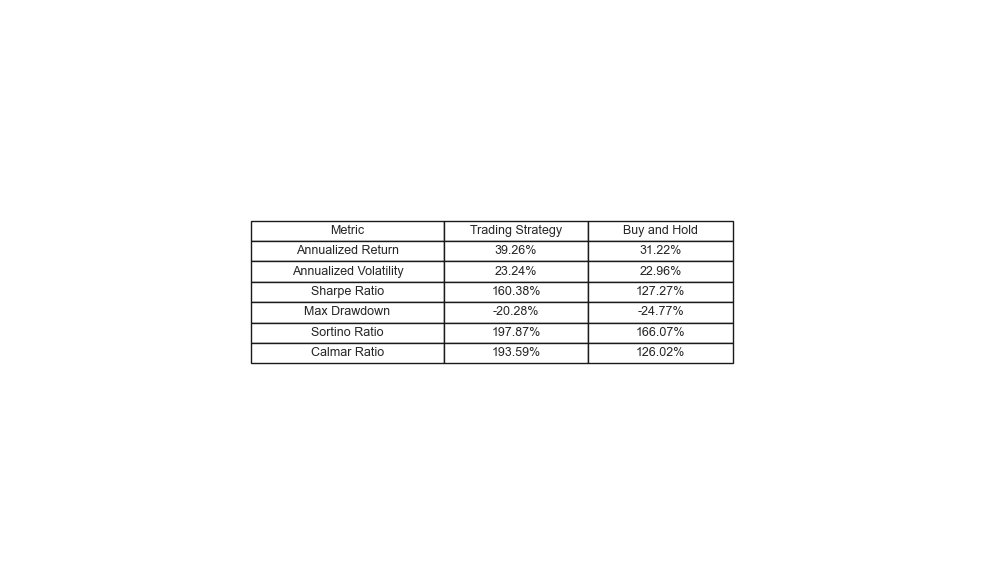

'╒═══════════════════════╤════════════════════╤════════════════╕\n│ Metric                │ Trading Strategy   │ Buy and Hold   │\n╞═══════════════════════╪════════════════════╪════════════════╡\n│ Annualized Return     │ 39.26%             │ 31.22%         │\n├───────────────────────┼────────────────────┼────────────────┤\n│ Annualized Volatility │ 23.24%             │ 22.96%         │\n├───────────────────────┼────────────────────┼────────────────┤\n│ Sharpe Ratio          │ 160.38%            │ 127.27%        │\n├───────────────────────┼────────────────────┼────────────────┤\n│ Max Drawdown          │ -20.28%            │ -24.77%        │\n├───────────────────────┼────────────────────┼────────────────┤\n│ Sortino Ratio         │ 197.87%            │ 166.07%        │\n├───────────────────────┼────────────────────┼────────────────┤\n│ Calmar Ratio          │ 193.59%            │ 126.02%        │\n╘═══════════════════════╧════════════════════╧════════════════╛'

In [196]:
# Exécuter les deux stratégies et obtenir les résultats
apply_trading_results = apply_trading_strategy(bb_signals, rsi_signals, macd_signals, test_set_prices)
buy_and_hold_results = buy_and_hold_strategy(test_set_prices)

# Comparaison des portfolios avec un graphique
plot_portfolio_comparison(apply_trading_results[1], buy_and_hold_results, labels=["Trading Strategy", "Buy and Hold"])

# Comparaison des métriques de performance
metrics_comparison = compare_strategies_metrics(apply_trading_results[1], buy_and_hold_results, labels=["Trading Strategy", "Buy and Hold"])

# Créer le tableau de comparaison
create_performance_table(metrics_comparison, labels=["Trading Strategy", "Buy and Hold"])

                                                 Trading Strategy  \
Annualized Return      Portfolio Value    0.392645
dtype: float64   
Annualized Volatility  Portfolio Value    0.232358
dtype: float64   
Sharpe Ratio            Portfolio Value    1.60375
dtype: float64   
Max Drawdown           Portfolio Value   -0.202823
dtype: float64   
Sortino Ratio          Portfolio Value    1.978661
dtype: float64   
Calmar Ratio           Portfolio Value    1.935902
dtype: float64   

                                                     Buy and Hold  
Annualized Return      Portfolio Value    0.312169
dtype: float64  
Annualized Volatility  Portfolio Value    0.229571
dtype: float64  
Sharpe Ratio           Portfolio Value    1.272675
dtype: float64  
Max Drawdown           Portfolio Value   -0.247712
dtype: float64  
Sortino Ratio           Portfolio Value    1.66066
dtype: float64  
Calmar Ratio           Portfolio Value    1.260211
dtype: float64  


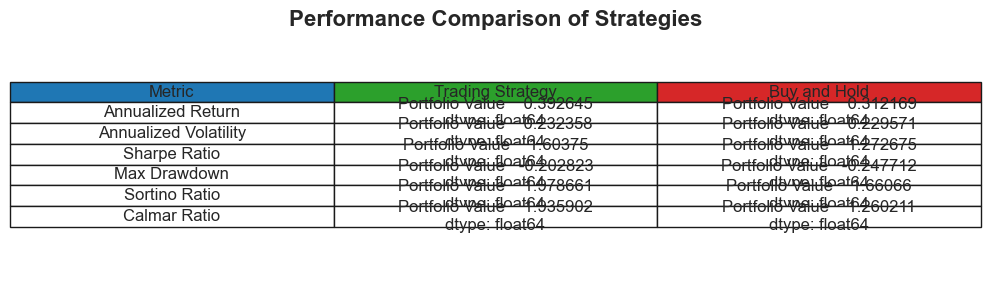

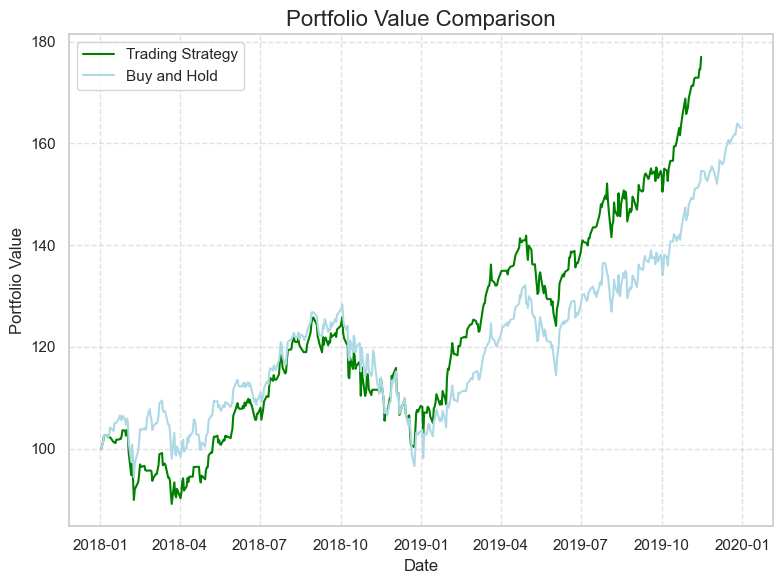

                                                 Trading Strategy  \
Annualized Return      Portfolio Value    0.392645
dtype: float64   
Annualized Volatility  Portfolio Value    0.232358
dtype: float64   
Sharpe Ratio            Portfolio Value    1.60375
dtype: float64   
Max Drawdown           Portfolio Value   -0.202823
dtype: float64   
Sortino Ratio          Portfolio Value    1.978661
dtype: float64   
Calmar Ratio           Portfolio Value    1.935902
dtype: float64   

                                                     Buy and Hold  
Annualized Return      Portfolio Value    0.312169
dtype: float64  
Annualized Volatility  Portfolio Value    0.229571
dtype: float64  
Sharpe Ratio           Portfolio Value    1.272675
dtype: float64  
Max Drawdown           Portfolio Value   -0.247712
dtype: float64  
Sortino Ratio           Portfolio Value    1.66066
dtype: float64  
Calmar Ratio           Portfolio Value    1.260211
dtype: float64  


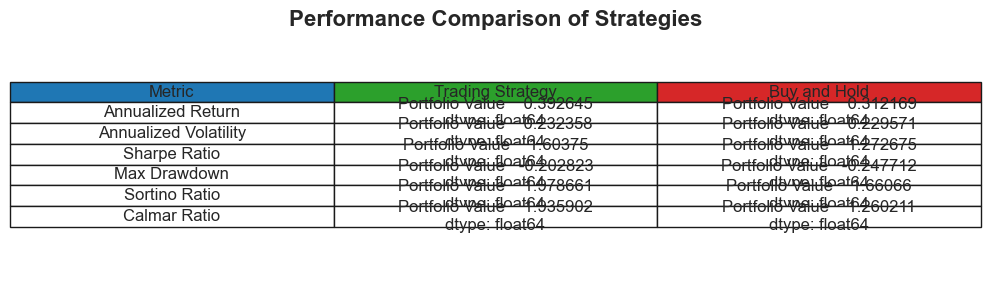

In [205]:
import matplotlib.pyplot as plt
from matplotlib import style
from tabulate import tabulate
import seaborn as sns
import pandas as pd

# Function to plot portfolio returns comparison
def plot_portfolio_returns(apply_trading_results, buy_and_hold_results):
    plt.figure(figsize=(8, 6))  # Adjust size
    plt.plot(apply_trading_results.index, apply_trading_results['Portfolio Value'], color='green', linewidth=1.5, label='Trading Strategy')
    plt.plot(buy_and_hold_results.index, buy_and_hold_results['Portfolio Value'], color='lightblue', linewidth=1.5, label='Buy and Hold')
    plt.title('Portfolio Value Comparison', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Portfolio Value', fontsize=12)
    plt.legend(loc="upper left")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def create_performance_table(metrics_comparison, labels):
    # Convert the metrics comparison dictionary into a DataFrame
    table_df = pd.DataFrame(metrics_comparison)

    # Ensure that there are exactly two columns for the comparison
    if table_df.shape[1] != len(labels):
        raise ValueError(f"Expected {len(labels)} columns, but got {table_df.shape[1]}.")

    # Rename the columns with the strategy labels
    table_df.columns = labels

    # Create a figure for the table
    fig, ax = plt.subplots(figsize=(10, 3))  # Adjust the size of the table
    ax.axis('tight')
    ax.axis('off')

    # Create the table with custom style using matplotlib's table method
    table_data = table_df.reset_index().values
    col_labels = ["Metric"] + list(table_df.columns)
    table = ax.table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='center', colColours=["#1f77b4", "#2ca02c", "#d62728"])

    # Set the font size and the layout
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)  # Make the table bigger

    # Display the table
    plt.title('Performance Comparison of Strategies', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example of how you'd use these functions:
# Assume `metrics_comparison` is already calculated
metrics_comparison = compare_strategies_metrics(apply_trading_results[1], buy_and_hold_results, labels=["Trading Strategy", "Buy and Hold"])

# Create the professional table
create_performance_table(metrics_comparison, labels=["Trading Strategy", "Buy and Hold"])

# Example of how you'd use these functions:
# Compare the portfolio performance metrics and plot the results
plot_portfolio_returns(apply_trading_results[1], buy_and_hold_results)

metrics_comparison = compare_strategies_metrics(apply_trading_results[1], buy_and_hold_results, labels=["Trading Strategy", "Buy and Hold"])

# Create the colorful table
create_performance_table(metrics_comparison, labels=["Trading Strategy", "Buy and Hold"])

<Axes: xlabel='Date'>

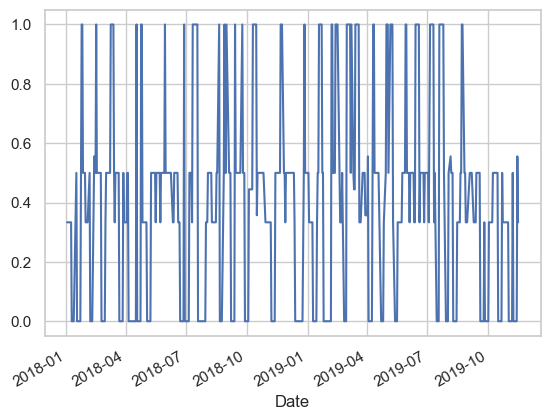

In [222]:
# Run the trading strategy and get the positions and portfolio values
pos_df, _ = apply_trading_strategy(bb_signals, rsi_signals, macd_signals, test_set_prices)

# Calculate the Risk-Free Rate
pos_df['Risk-Free Rate'] = 1 - (pos_df['AAPL'] + pos_df['GOOG'] + pos_df['MSFT'])

# Rearranging the columns to have Risk-Free Rate at the end
pos_df = pos_df[['AAPL', 'GOOG', 'MSFT', 'Risk-Free Rate']]
pos_df.columns= ['Apple', 'Google', 'Microsoft','Risk-Free Rate']


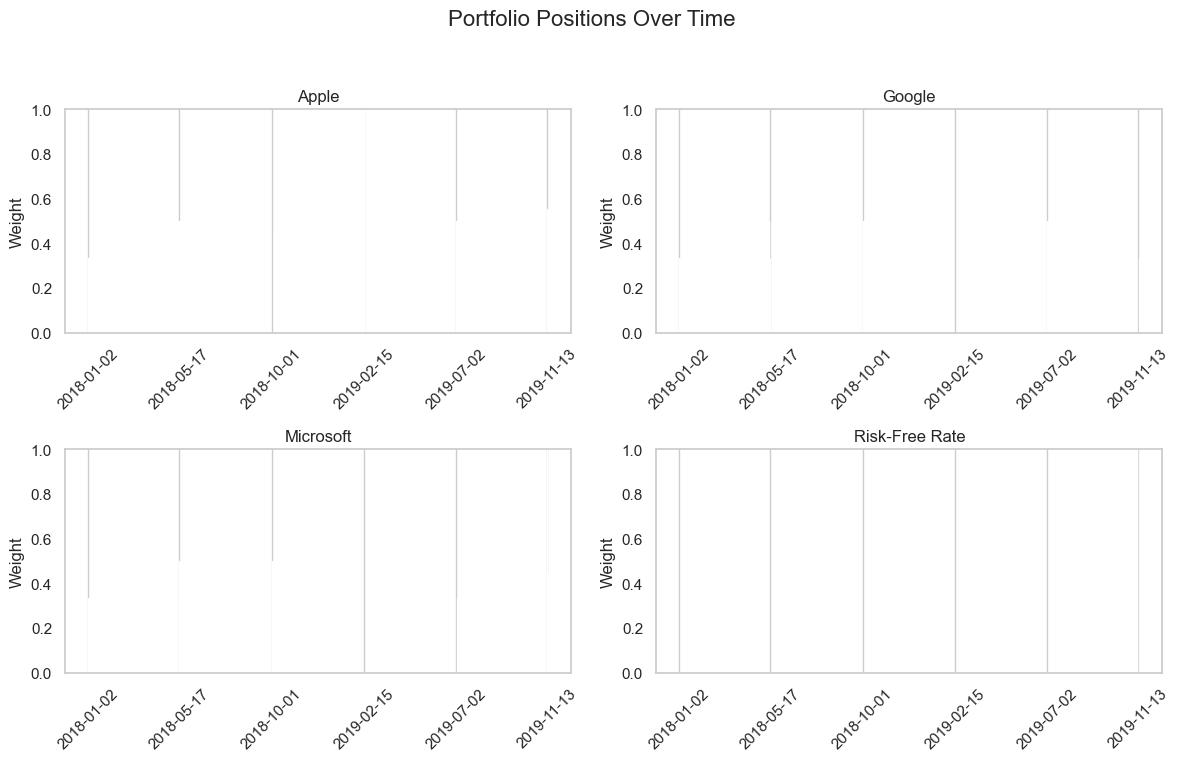

In [227]:
import matplotlib.pyplot as plt

# Ensure the Risk-Free Rate is calculated correctly
pos_df['Risk-Free Rate'] = 1 - (pos_df['Apple'] + pos_df['Google'] + pos_df['Microsoft'])

# Create a subplot for each position column
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))  # 2 rows, 2 columns
fig.suptitle('Portfolio Positions Over Time', fontsize=16)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plotting each position
for i, (column_name, ax) in enumerate(zip(pos_df.columns, axes)):
    ax.bar(pos_df.index, pos_df[column_name], color='lightblue' if column_name != 'Risk-Free Rate' else 'lightgreen')
    ax.set_title(column_name)
    ax.set_ylabel('Weight')
    ax.set_ylim(0, 1)  # Ensure y-axis is from 0 to 1
    ax.grid(axis='y')

    # Set the x-ticks to show a few selected dates
    ax.set_xticks(pos_df.index[::int(len(pos_df.index) / 5)])  # Show 5 ticks evenly spaced
    ax.set_xticklabels(pos_df.index[::int(len(pos_df.index) / 5)].date, rotation=45)  # Rotate for better visibility

# Hide the last subplot if there's an empty space
if len(pos_df.columns) < 4:
    fig.delaxes(axes[-1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
plt.show()

In [1]:
pos_df

NameError: name 'pos_df' is not defined